In [8]:
import time
import numpy as np
import pandas as pd
import os

import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [2]:
data_dir = "D:/Colon_200"
img_height, img_width = 224, 224

In [3]:
image_counts = {}

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    
    if os.path.isdir(folder_path):
        image_counts[folder_name] = len(os.listdir(folder_path))

for folder, count in image_counts.items():
    print(f'Number of images in {folder}: {count}')

total_images = sum(image_counts.values())
print(f'Total number of images: {total_images}')

Number of images in Colon_aca: 500
Number of images in Colon_n: 500
Total number of images: 1000


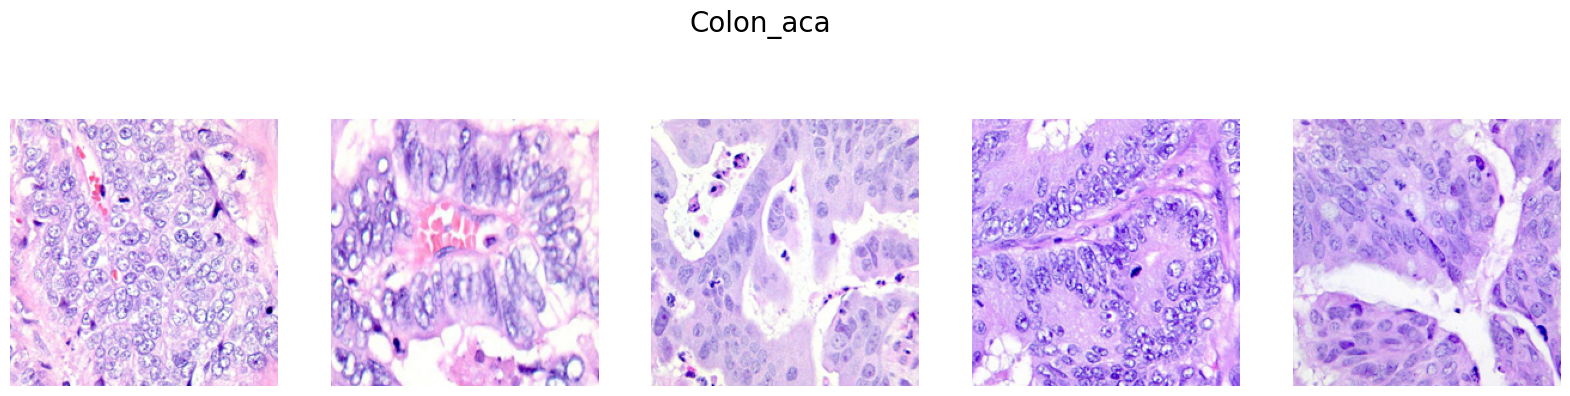

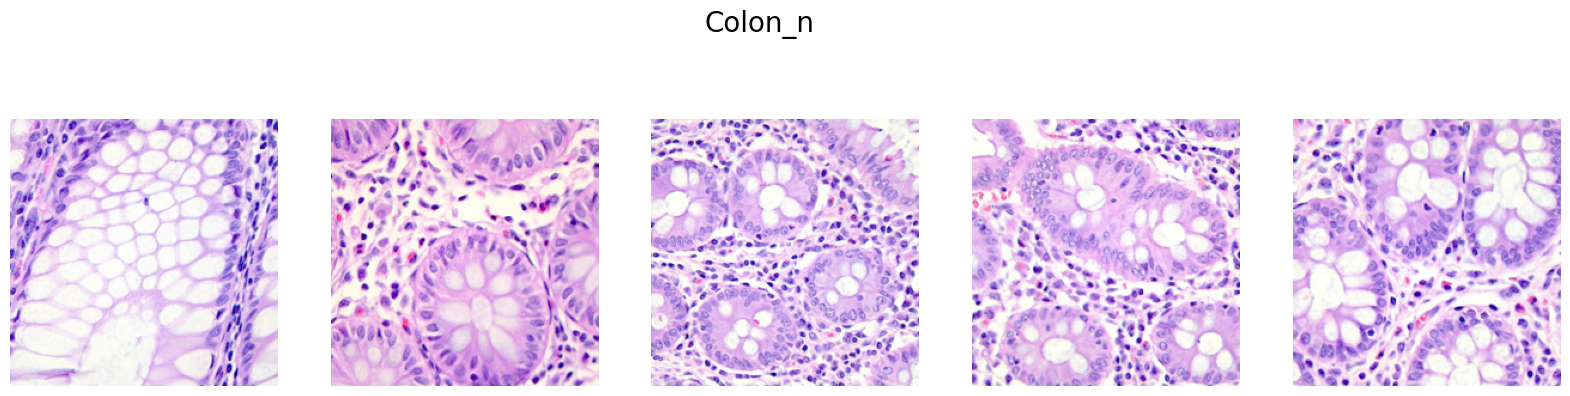

In [4]:
def display_images_from_folder(folder_name, images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle(folder_name, fontsize=20)
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    
    if os.path.isdir(folder_path):
        image_files = os.listdir(folder_path)[:5]  
        
        images = []
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            img = Image.open(image_path)
            img = img.resize((img_width, img_height))
            images.append(img)
      
        display_images_from_folder(folder_name, images)

In [9]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

# Step 1: Load and preprocess images for colon dataset
colon_cancerous_folder = "D:/Colon_200/Colon_aca"  # Replace with your folder path
colon_non_cancerous_folder = "D:/Colon_200/Colon_n"  # Replace with your folder path

# Load and preprocess images for each class
colon_cancerous_images, colon_cancerous_labels = load_and_preprocess_images(colon_cancerous_folder, 0)
colon_non_cancerous_images, colon_non_cancerous_labels = load_and_preprocess_images(colon_non_cancerous_folder, 1)

# Combine data from both classes
all_images = np.concatenate((colon_cancerous_images, colon_non_cancerous_images), axis=0)
all_labels = np.concatenate((colon_cancerous_labels, colon_non_cancerous_labels), axis=0)

# Step 2: Split the dataset into training and testing sets, with stratification for balanced classes
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

In [10]:
# Check the distribution of classes in y_train and y_test
print("Unique values in y_train:", np.unique(y_train, return_counts=True))
print("Unique values in y_test:", np.unique(y_test, return_counts=True))

Unique values in y_train: (array([0, 1]), array([400, 400], dtype=int64))
Unique values in y_test: (array([0, 1]), array([100, 100], dtype=int64))


In [11]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Encoder Model
encoder = Sequential([
    base_model,
    GlobalAveragePooling2D()
])

In [13]:
# Measure time for feature extraction
start_time = time.time()
X_train_features = encoder.predict(X_train)
X_test_features = encoder.predict(X_test)
end_time = time.time()

print(f"Time taken for ResNet50 feature extraction: {end_time - start_time:.2f} seconds")
print(f'Total number of features extracted using ResNet50: {X_train_features.shape[1]}')
print(f'Dimensions of extracted features before flattening: {base_model.output.shape}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Time taken for ResNet50 feature extraction: 37.43 seconds
Total number of features extracted using ResNet50: 2048
Dimensions of extracted features before flattening: (None, 7, 7, 2048)


In [15]:
# Decoder Model
decoder = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_features.shape[1],)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
])

# Measure time for decoding
start_time = time.time()
X_train_decoded = decoder.predict(X_train_features)
X_test_decoded = decoder.predict(X_test_features)
end_time = time.time()

print(f"Time taken for feature decoding: {end_time - start_time:.2f} seconds")
print(f'Total number of features after decoding: {X_train_decoded.shape[1]}')
print(f'Dimensions of decoded features: {X_train_decoded.shape}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Time taken for feature decoding: 0.22 seconds
Total number of features after decoding: 256
Dimensions of decoded features: (800, 256)


In [16]:
# Standardize features
scaler = StandardScaler()
start_time = time.time()
X_train_scaled = scaler.fit_transform(X_train_decoded)
X_test_scaled = scaler.transform(X_test_decoded)
end_time = time.time()

print(f"Time taken for feature scaling: {end_time - start_time:.2f} seconds")

Time taken for feature scaling: 0.00 seconds


In [17]:
# Apply PCA
pca = PCA(n_components=50)
start_time = time.time()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
end_time = time.time()

print(f"Time taken for PCA transformation: {end_time - start_time:.2f} seconds")
print(f'Total number of features after PCA: {X_train_pca.shape[1]}')
print(f'Dimensions of PCA-transformed features: {X_train_pca.shape}')

Time taken for PCA transformation: 0.18 seconds
Total number of features after PCA: 50
Dimensions of PCA-transformed features: (800, 50)


In [18]:
from sklearn.svm import SVC

In [19]:
svm_classifier = SVC(random_state=42, probability=True)
svm_classifier.fit(X_train_pca, y_train)

SVC(probability=True, random_state=42)

In [20]:
y_pred_svc = svm_classifier.predict(X_test_pca)

Support Vector Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       100
           1       0.91      0.84      0.88       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200

Support Vector Confusion Matrix:
[[92  8]
 [16 84]]


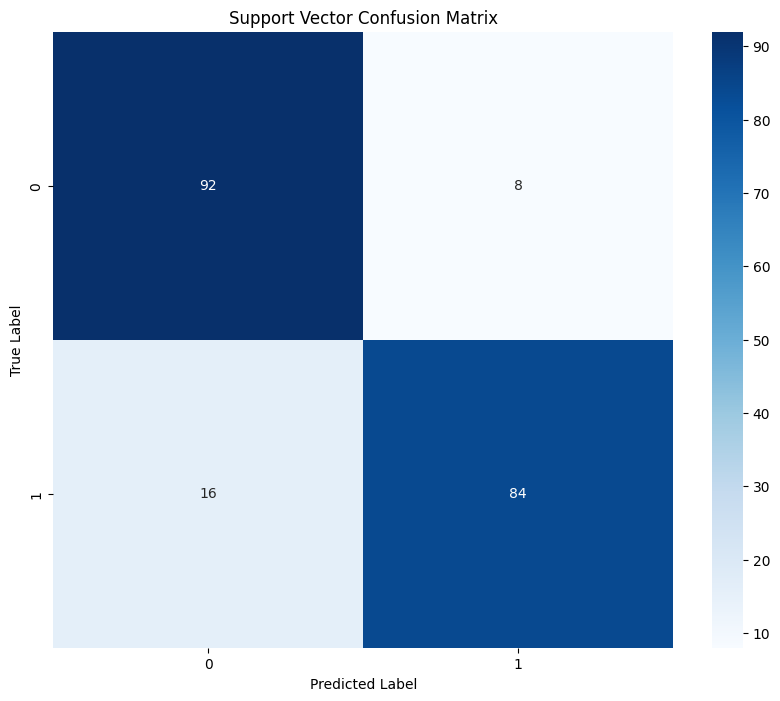

In [21]:
print("Support Vector Classification Report:")
print(classification_report(y_test, y_pred_svc))

print("Support Vector Confusion Matrix:")
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
print(conf_matrix_svc)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to th

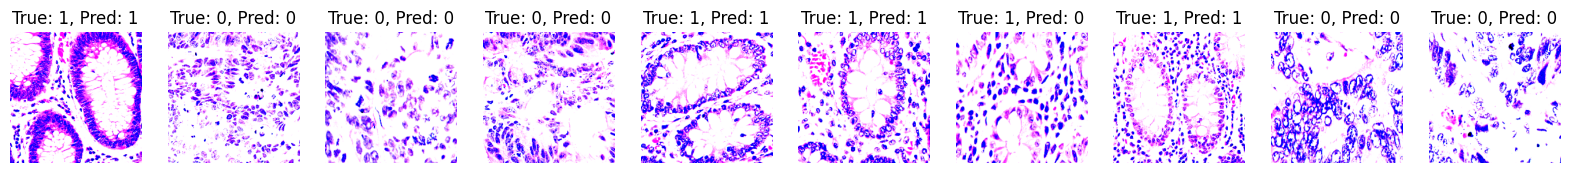

In [22]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_svc[i]}")

plt.show()

In [23]:
param_grid = {
    'C': [0.1, 1, 10, 100],           
    'gamma': [1, 0.1, 0.01, 0.001],   
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  
}

In [24]:
from sklearn.model_selection import GridSearchCV

svm = SVC(random_state=42, probability=True)

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search_svm.fit(X_train_pca, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=2)

In [25]:
best_params = grid_search_svm.best_params_
best_estimator = grid_search_svm.best_estimator_

print("Best parameters found: ", best_params)
print("Best estimator found: ", best_estimator)

Best parameters found:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator found:  SVC(C=10, gamma=0.01, probability=True, random_state=42)


In [26]:
best_model = grid_search_svm.best_estimator_

y_pred_svc = best_model.predict(X_test_pca)

Support Vector Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       100
           1       0.87      0.86      0.86       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200

Support Vector Confusion Matrix:
[[87 13]
 [14 86]]


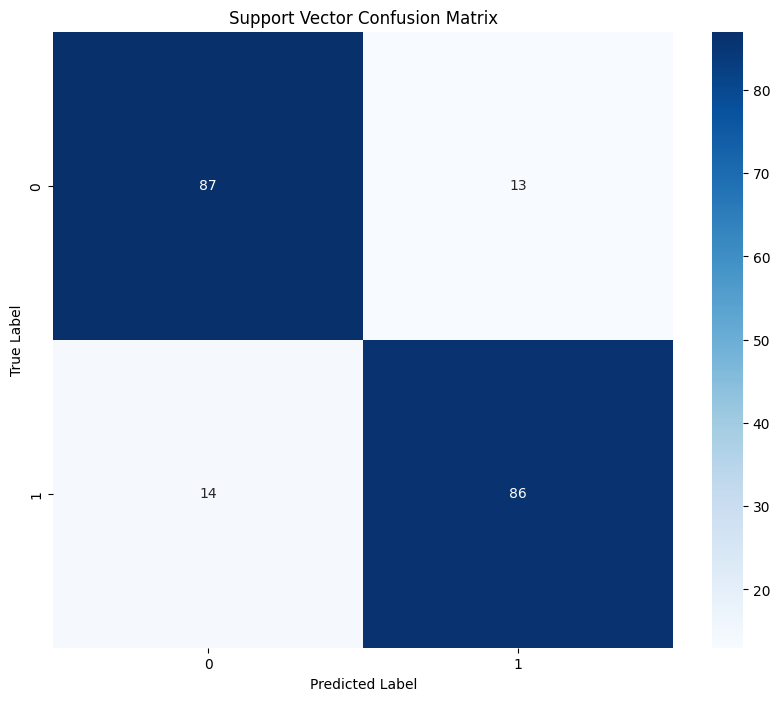

In [27]:
print("Support Vector Classification Report:")
print(classification_report(y_test, y_pred_svc))

print("Support Vector Confusion Matrix:")
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
print(conf_matrix_svc)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to th

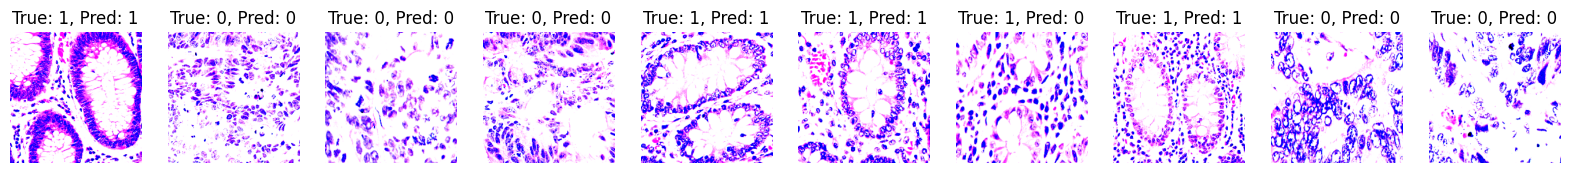

In [28]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_svc[i]}")

plt.show()

In [29]:
# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_model, X_train_pca, y_train, cv=cv, scoring='accuracy')

In [30]:
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean()}")

Cross-Validation Scores: [0.9125 0.975  0.9    0.9625 0.925  0.9125 0.975  0.9125 0.925  0.95  ]
Mean Cross-Validation Score: 0.9349999999999999


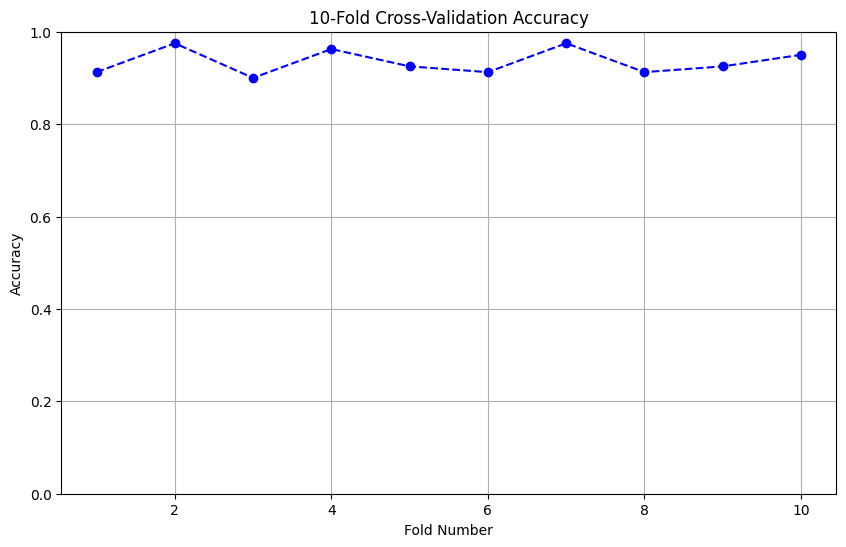

In [31]:
# Plot 10-fold cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cross_val_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Accuracy')
plt.ylim(0.0, 1.0)
plt.grid()
plt.show()

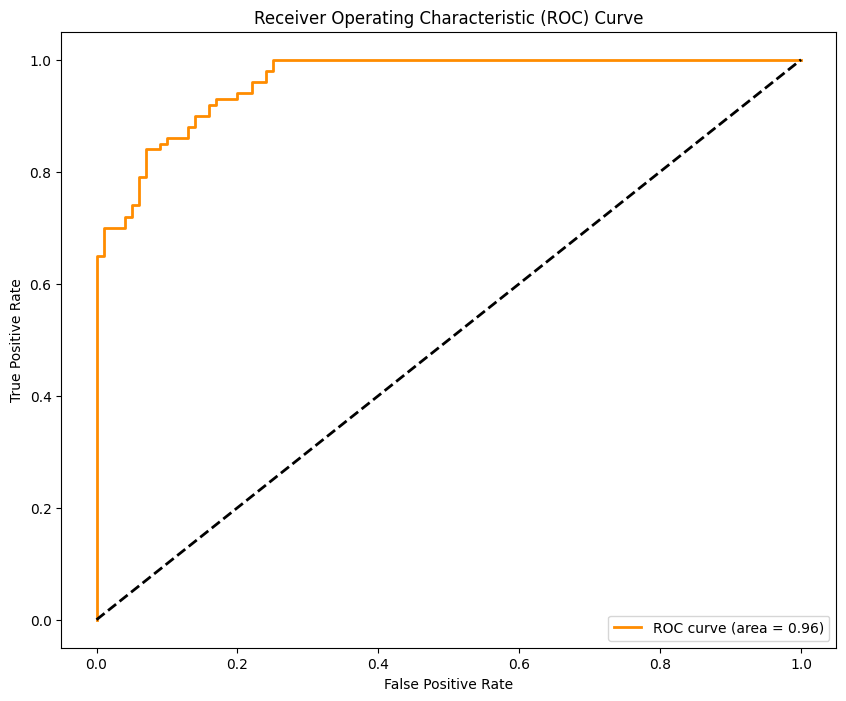

In [32]:
y_pred_proba = best_model.predict_proba(X_test_pca)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Deep Learning

In [33]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [35]:
# Define the neural network model with dropout layers
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Convert labels to categorical
y_train_1 = to_categorical(y_train, num_classes=6)
y_test_1 = to_categorical(y_test, num_classes=6)

In [38]:
# Print the number of features at each stage
print(f"Number of features after DenseNet-121 extraction: {X_train_features.shape[1]}")
print(f"Number of features after decoding: {X_train_decoded.shape[1]}")
print(f"Number of features after PCA: {X_train_pca.shape[1]}")

Number of features after DenseNet-121 extraction: 2048
Number of features after decoding: 256
Number of features after PCA: 50


In [39]:
# Train the model
history = model.fit(X_train_pca, y_train_1, validation_data=(X_test_pca, y_test_1), epochs=10, batch_size=32)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5703 - loss: 1.0797 - val_accuracy: 0.8250 - val_loss: 0.3841
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474 - loss: 0.3948 - val_accuracy: 0.8700 - val_loss: 0.3017
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.3174 - val_accuracy: 0.8600 - val_loss: 0.2938
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9136 - loss: 0.2269 - val_accuracy: 0.8600 - val_loss: 0.3479
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.1790 - val_accuracy: 0.8650 - val_loss: 0.3675
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9289 - loss: 0.1540 - val_accuracy: 0.8800 - val_loss: 0.4670
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9391 - loss: 0.1558 - val_accuracy: 0.8750 - val_loss: 0.3872
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9373 - loss: 0.1314 - val_accuracy: 0.8800 - val_loss

In [40]:
# Make predictions
y_pred_prob = model.predict(X_test_pca)
y_pred = y_pred_prob.argmax(axis=-1)
y_test_labels = y_test_1.argmax(axis=-1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [41]:
print("Sample predictions:", y_pred[:10])
print("Sample true labels:", y_test_labels[:10])

Sample predictions: [1 0 0 0 1 1 0 1 0 0]
Sample true labels: [1 0 0 0 1 1 1 1 0 0]


In [42]:
# Plot training and validation accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)

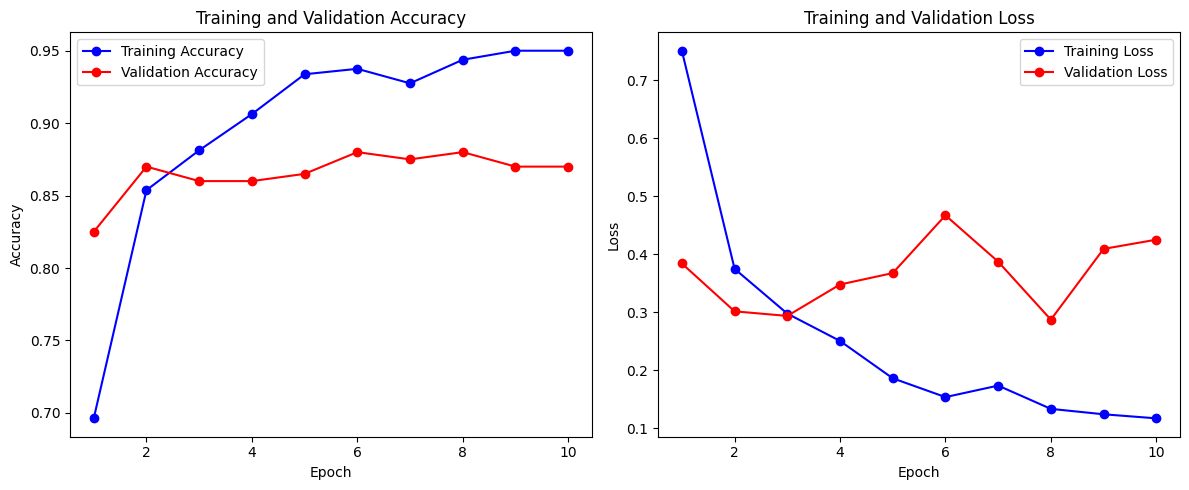

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Confusion Matrix:
[[92  8]
 [18 82]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       100
           1       0.91      0.82      0.86       100

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



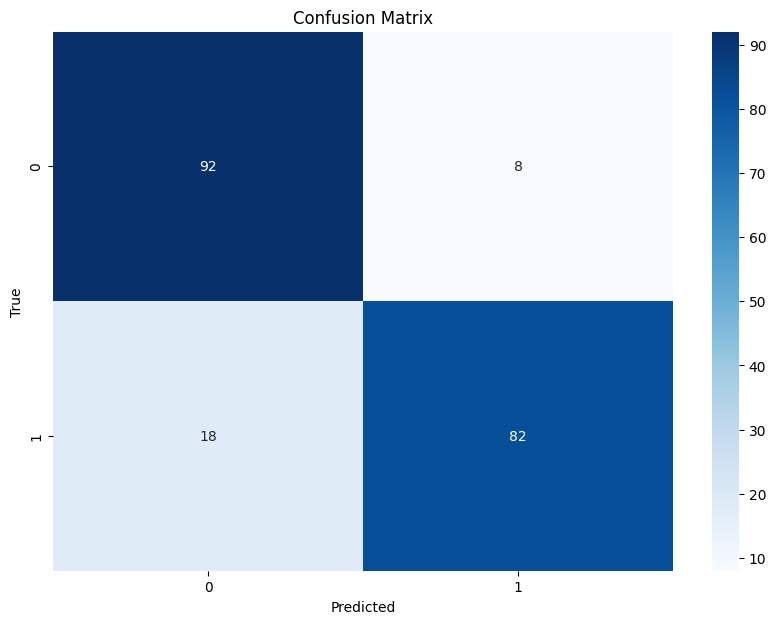

In [44]:
conf_matrix = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test_labels, y_pred)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [45]:
# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [46]:
def cross_val_keras_model(model, X, y, cv):
    val_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model_fold = Sequential([
            Dense(256, activation='relu', input_shape=(X.shape[1],)),
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(6, activation='softmax')
        ])

        model_fold.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        y_train_fold_cat = to_categorical(y_train_fold, num_classes=6)
        y_val_fold_cat = to_categorical(y_val_fold, num_classes=6)

        model_fold.fit(X_train_fold, y_train_fold_cat, epochs=10, batch_size=32, verbose=0)
        val_loss, val_accuracy = model_fold.evaluate(X_val_fold, y_val_fold_cat, verbose=0)
        val_scores.append(val_accuracy)

    return val_scores

In [48]:
cross_val_scores_keras = cross_val_keras_model(model, X_train_pca, y_train, cv)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
print(f"Cross-Validation Scores: {cross_val_scores_keras}")
print(f"Mean Cross-Validation Score: {np.mean(cross_val_scores_keras)}")

Cross-Validation Scores: [0.887499988079071, 0.949999988079071, 0.9375, 0.949999988079071, 0.9375, 0.9375, 0.9750000238418579, 0.925000011920929, 0.9624999761581421, 0.9125000238418579]
Mean Cross-Validation Score: 0.9375


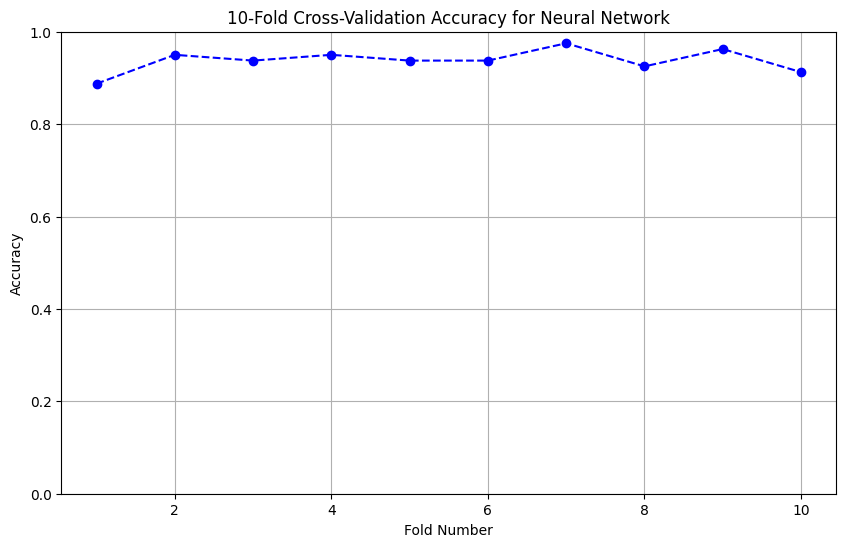

In [50]:
# Plot 10-fold cross-validation scores for the neural network
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cross_val_scores_keras, marker='o', linestyle='--', color='b')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Accuracy for Neural Network')
plt.ylim(0.0, 1.0)  # Adjust the y-axis limits based on your accuracy range
plt.grid()
plt.show()

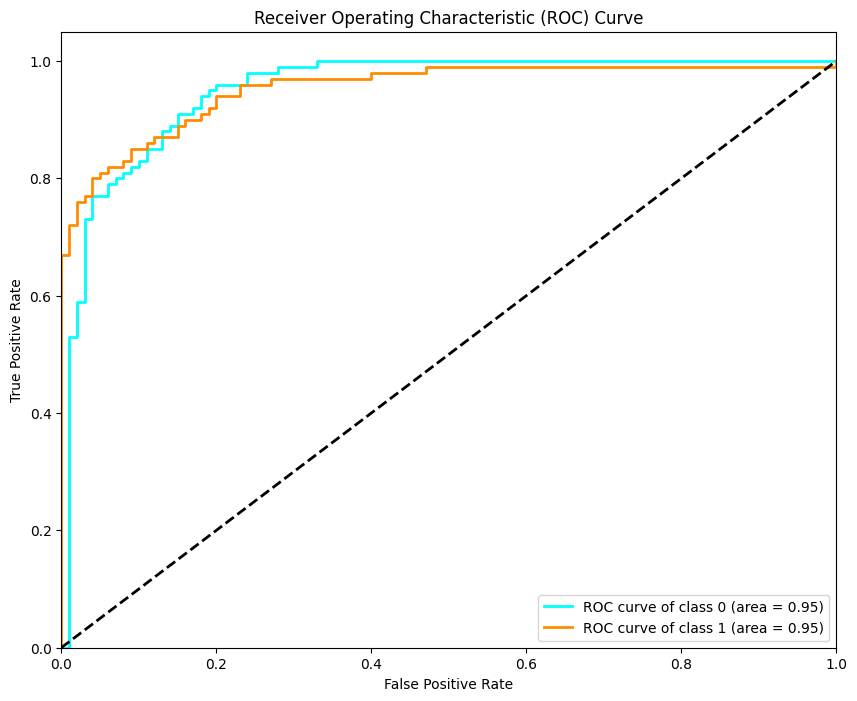

In [51]:
# ROC curve for the neural network model
fpr = {}
tpr = {}
roc_auc = {}

unique_classes = np.unique(y_test_labels)

for i in unique_classes:
    fpr[i], tpr[i], _ = roc_curve(y_test_labels == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(unique_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Deep Learning Architecture - 2

In [52]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

In [54]:
# Define the neural network model with dropout layers
model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [55]:
# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
# Train the model
history = model.fit(X_train_pca, y_train_1, validation_data=(X_test_pca, y_test_1), epochs=20, batch_size=32)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4755 - loss: 1.4247 - val_accuracy: 0.8350 - val_loss: 0.4100
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8092 - loss: 0.6050 - val_accuracy: 0.8450 - val_loss: 0.3392
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8589 - loss: 0.3600 - val_accuracy: 0.8800 - val_loss: 0.2595
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8870 - loss: 0.2919 - val_accuracy: 0.8800 - val_loss: 0.3128
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9328 - loss: 0.1949 - val_accuracy: 0.8800 - val_loss: 0.3504
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9184 - loss: 0.2410 - val_accuracy: 0.9000 - val_loss: 0.2295
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9176 - loss: 0.1984 - val_accuracy: 0.8850 - val_loss: 0.3611
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9426 - loss: 0.1497 - val_accuracy: 0.8650 - val_loss

In [58]:
# Make predictions
y_pred_prob = model.predict(X_test_pca)
y_pred = y_pred_prob.argmax(axis=-1)
y_test_labels = y_test_1.argmax(axis=-1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [59]:
print("Sample predictions:", y_pred[:10])
print("Sample true labels:", y_test_labels[:10])

Sample predictions: [1 0 0 0 1 1 1 1 0 0]
Sample true labels: [1 0 0 0 1 1 1 1 0 0]


In [60]:
# Plot training and validation accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)

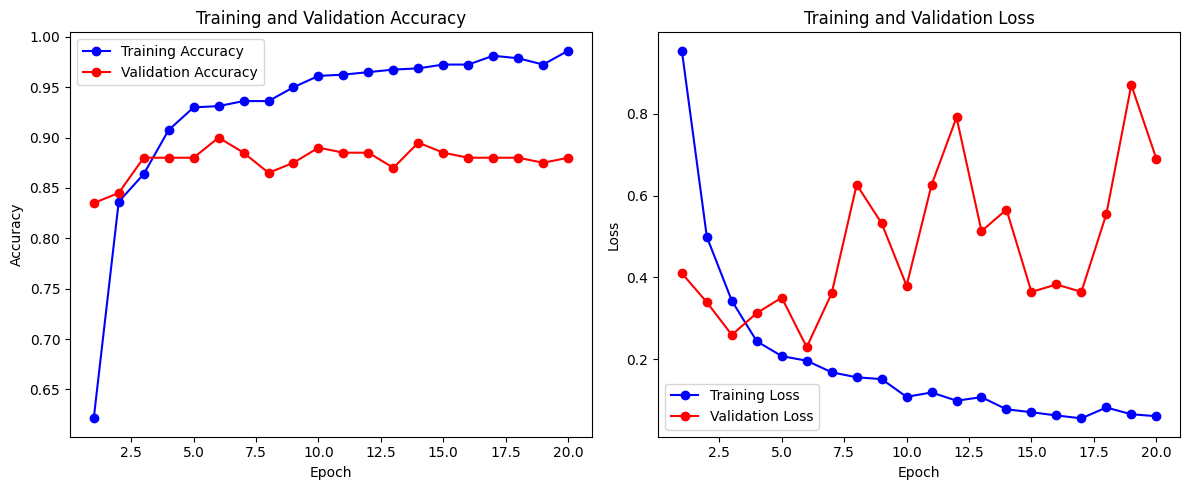

In [61]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion Matrix:
[[91  9]
 [15 85]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       100
           1       0.90      0.85      0.88       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



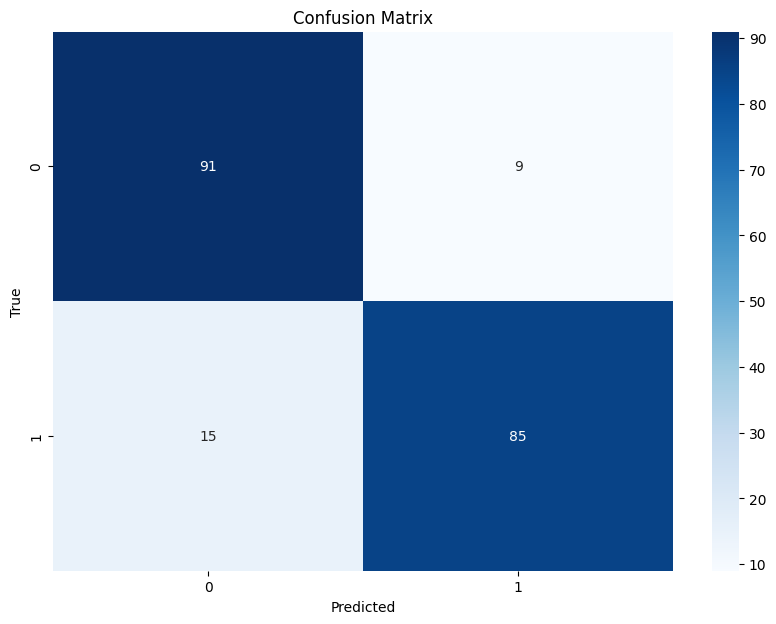

In [62]:
# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test_labels, y_pred)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [63]:
# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [64]:
def cross_val_keras_model(model, X, y, cv):
    val_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model_fold = Sequential([
            Dense(1024, activation='relu', input_shape=(X.shape[1],)),
            Dropout(0.5),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(6, activation='softmax')
        ])

        optimizer = Adam(learning_rate=0.001)
        model_fold.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        y_train_fold_cat = to_categorical(y_train_fold, num_classes=6)
        y_val_fold_cat = to_categorical(y_val_fold, num_classes=6)

        model_fold.fit(X_train_fold, y_train_fold_cat, epochs=20, batch_size=32, verbose=0)
        val_loss, val_accuracy = model_fold.evaluate(X_val_fold, y_val_fold_cat, verbose=0)
        val_scores.append(val_accuracy)

    return val_scores

In [65]:
cross_val_scores_keras = cross_val_keras_model(model, X_train_pca, y_train, cv)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
print(f"Cross-Validation Scores: {cross_val_scores_keras}")
print(f"Mean Cross-Validation Score: {np.mean(cross_val_scores_keras)}")

Cross-Validation Scores: [0.887499988079071, 0.9750000238418579, 0.9125000238418579, 0.9375, 0.875, 0.9624999761581421, 0.9624999761581421, 0.925000011920929, 0.949999988079071, 0.949999988079071]
Mean Cross-Validation Score: 0.9337499976158142


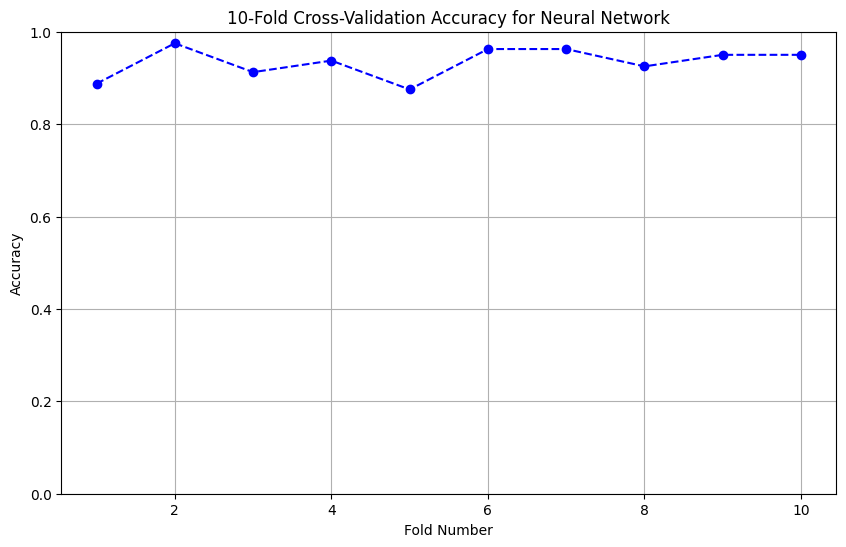

In [67]:
# Plot 10-fold cross-validation scores for the neural network
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cross_val_scores_keras, marker='o', linestyle='--', color='b')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Accuracy for Neural Network')
plt.ylim(0.0, 1.0)  # Adjust the y-axis limits based on your accuracy range
plt.grid()
plt.show()

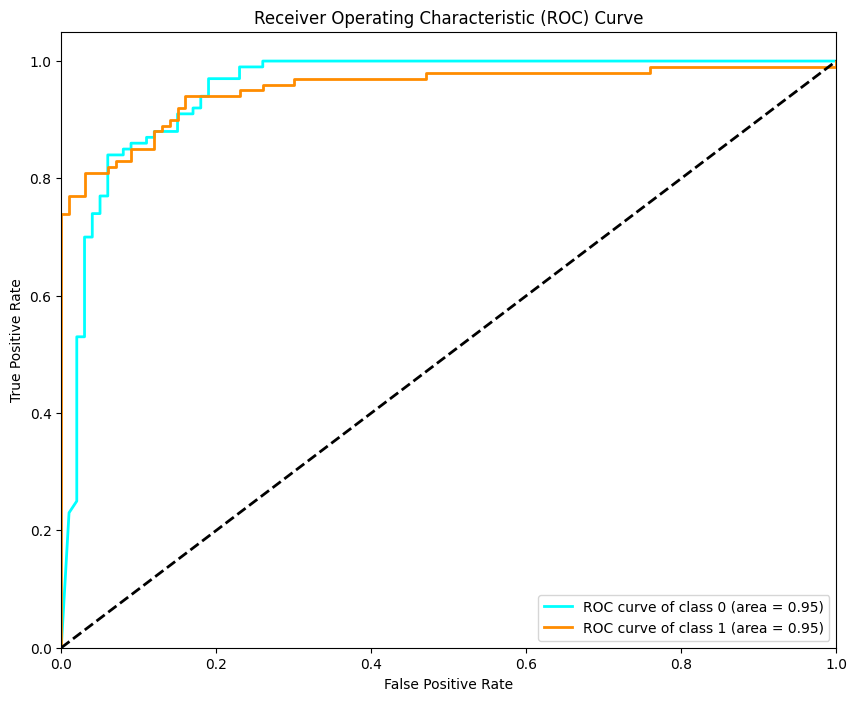

In [68]:
# ROC curve for the neural network model
fpr = {}
tpr = {}
roc_auc = {}

unique_classes = np.unique(y_test_labels)

for i in unique_classes:
    fpr[i], tpr[i], _ = roc_curve(y_test_labels == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(unique_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Logistic Regression

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

In [70]:
# Define and fit the Logistic Regression model
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train_pca, y_train)

LogisticRegression(random_state=42)

In [71]:
# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(logistic_regression, X_train_pca, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy Score from 10-Fold Cross-Validation:", cv_scores.mean())

10-Fold Cross-Validation Accuracy Scores: [0.95   0.9    0.875  0.9625 0.9125 0.95   0.8    0.925  0.9    0.9625]
Mean Accuracy Score from 10-Fold Cross-Validation: 0.9137500000000001


In [72]:
# Predict probabilities for ROC curve
y_pred_prob_lr = logistic_regression.predict_proba(X_test_pca)[:, 1]

In [73]:
# Fit and evaluate using Grid Search with Cross-Validation
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
}

In [74]:
import warnings
warnings.filterwarnings("ignore")

logistic_regression_gv = LogisticRegression(random_state=42)

grid_search_lr = GridSearchCV(logistic_regression_gv, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [75]:
best_params = grid_search_lr.best_params_
best_estimator = grid_search_lr.best_estimator_

print("Best parameters found: ", best_params)
print("Best estimator found: ", best_estimator)

Best parameters found:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator found:  LogisticRegression(C=0.01, random_state=42, solver='liblinear')


In [77]:
y_pred_lr = grid_search_lr.predict(X_test_pca)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       100
           1       0.91      0.81      0.86       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200

Logistic Regression Confusion Matrix:
[[92  8]
 [19 81]]


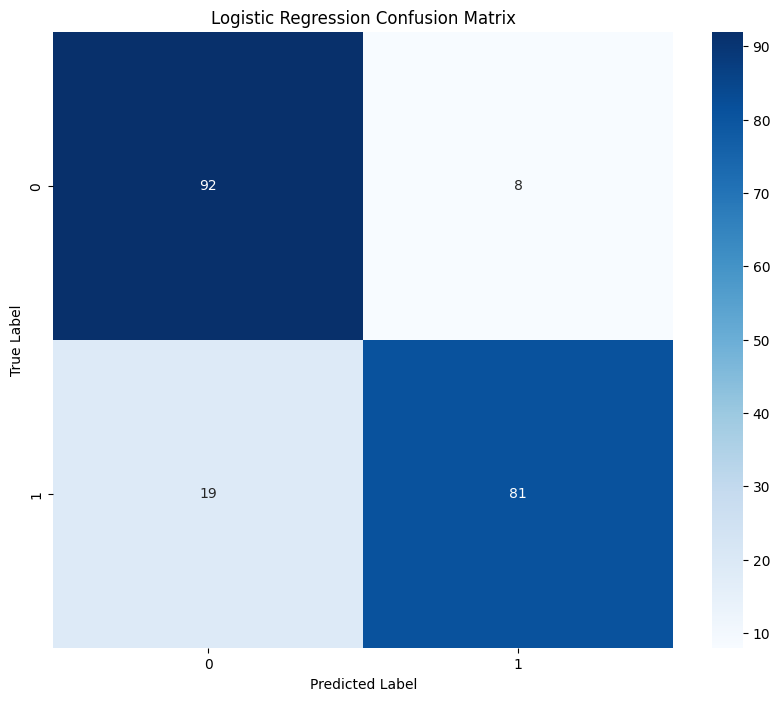

In [78]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Logistic Regression Confusion Matrix:")
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print(conf_matrix_lr)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to th

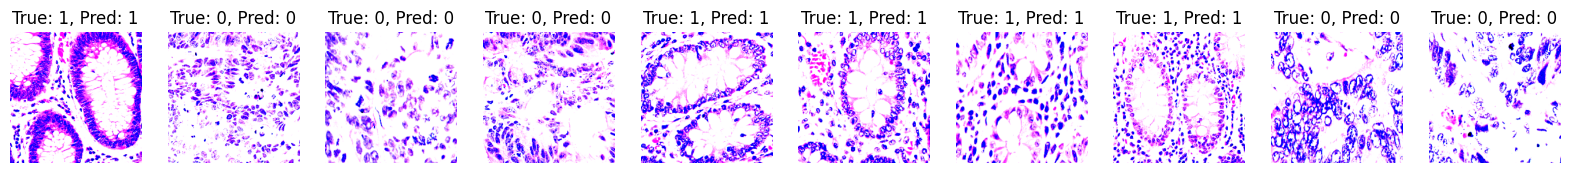

In [79]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_lr[i]}")

plt.show()

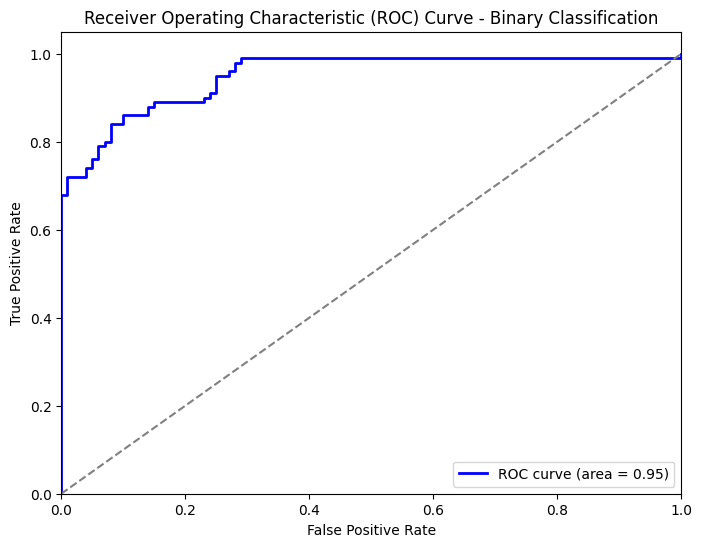

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities
y_pred_prob_lr = grid_search_lr.predict_proba(X_test_pca)[:, 1]  # Only need probabilities for class 1 in binary case

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Binary Classification')
plt.legend(loc="lower right")
plt.show()

# Random Forest Classifier

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [82]:
# Define and fit the Random Forest model
random_forest = RandomForestClassifier(n_estimators=300, random_state=42)
random_forest.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [83]:
# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(random_forest, X_train_pca, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy Score from 10-Fold Cross-Validation:", cv_scores.mean())

10-Fold Cross-Validation Accuracy Scores: [0.8625 0.9    0.85   0.9125 0.8625 0.9125 0.8625 0.9375 0.925  0.925 ]
Mean Accuracy Score from 10-Fold Cross-Validation: 0.8950000000000001


In [84]:
# Predict probabilities for ROC curve
y_pred_rf_prob = random_forest.predict_proba(X_test_pca)

In [85]:
# Fit and evaluate using Grid Search with Cross-Validation
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

In [86]:
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [87]:
grid_search_rf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [88]:
best_model = grid_search_rf.best_estimator_

In [89]:
y_pred_rf = best_model.predict(X_test_pca)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       100
           1       0.84      0.86      0.85       100

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200

Random Forest Confusion Matrix:
[[84 16]
 [14 86]]


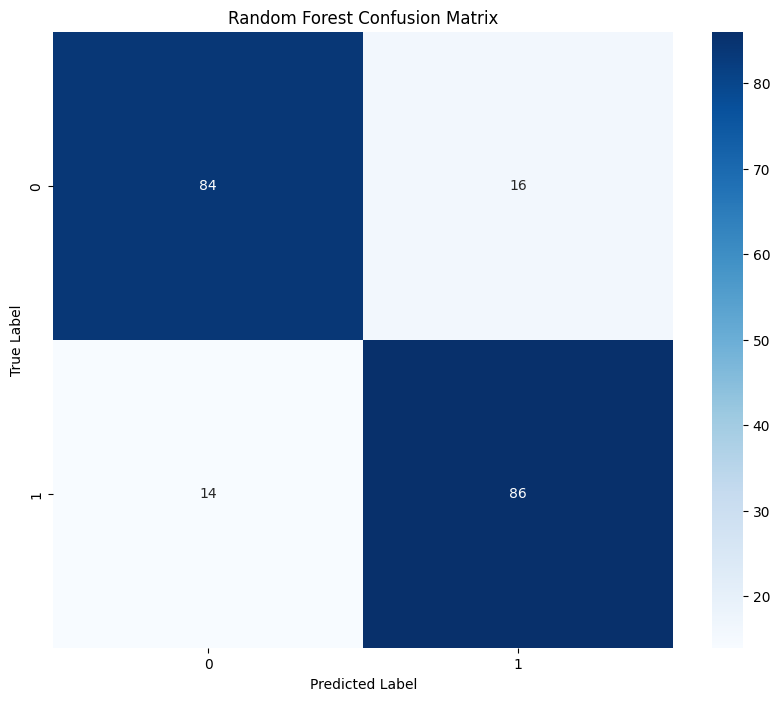

In [90]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest Confusion Matrix:")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to th

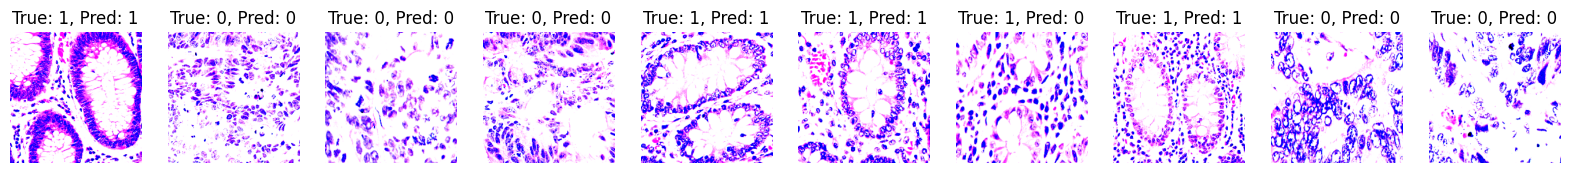

In [91]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_rf[i]}")

plt.show()

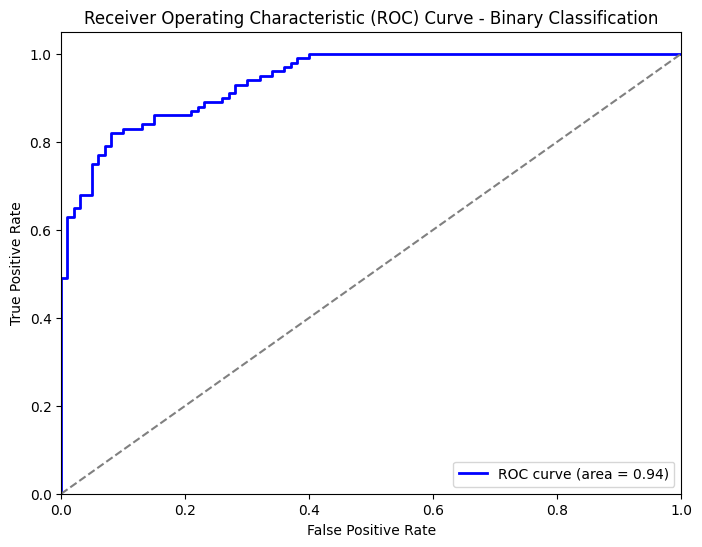

In [92]:
# Predict probabilities for the positive class
y_pred_rf_prob = grid_search_rf.predict_proba(X_test_pca)[:, 1]  # Only need probabilities for class 1 in binary case

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_rf_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Binary Classification')
plt.legend(loc="lower right")
plt.show()

# Decision Tree

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [94]:
# Define and fit the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_pca, y_train)

DecisionTreeClassifier(random_state=42)

In [95]:
# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(dt_model, X_train_pca, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy Score from 10-Fold Cross-Validation:", cv_scores.mean())

10-Fold Cross-Validation Accuracy Scores: [0.75   0.8125 0.8375 0.85   0.825  0.8125 0.8    0.825  0.85   0.8375]
Mean Accuracy Score from 10-Fold Cross-Validation: 0.82


In [96]:
# Predict probabilities for ROC curve
y_pred_dt_prob = dt_model.predict_proba(X_test_pca)

In [97]:
# Fit and evaluate using Grid Search with Cross-Validation
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [98]:
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search_dt.fit(X_train_pca, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [99]:
best_model = grid_search_dt.best_estimator_

y_pred_dt = best_model.predict(X_test_pca)

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       100
           1       0.81      0.78      0.80       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200

Decision Tree Confusion Matrix:
[[82 18]
 [22 78]]


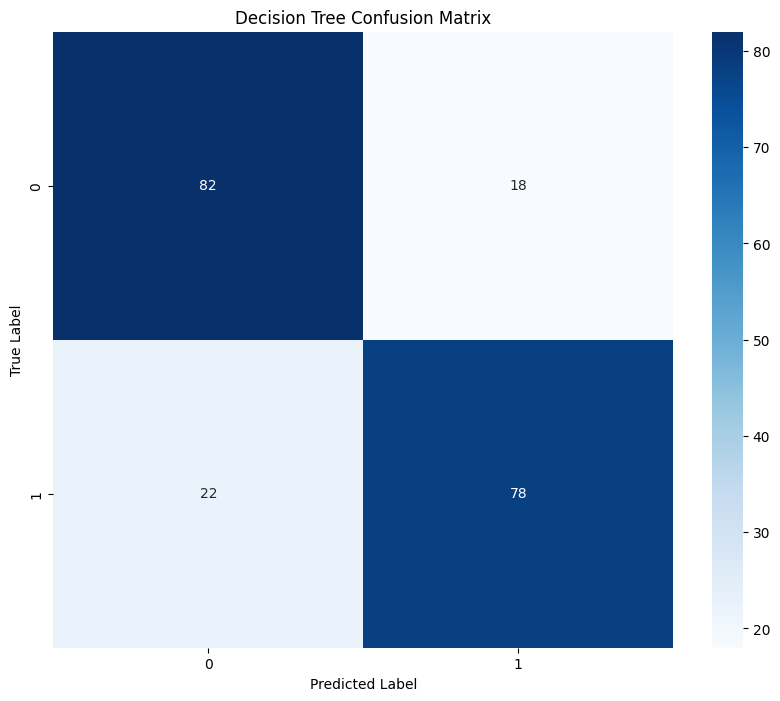

In [100]:
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Decision Tree Confusion Matrix:")
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print(conf_matrix_dt)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to th

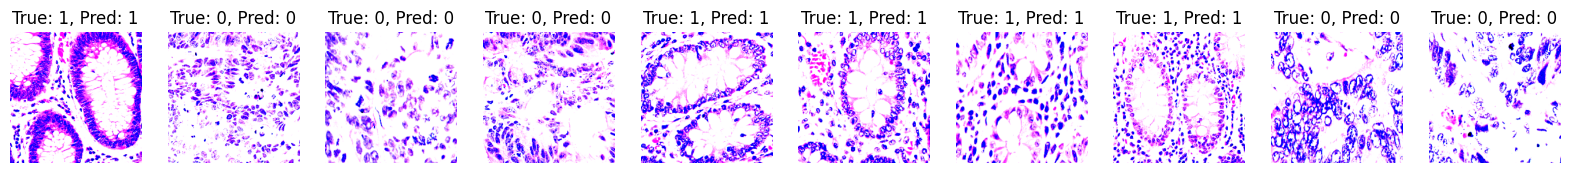

In [101]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_dt[i]}")

plt.show()

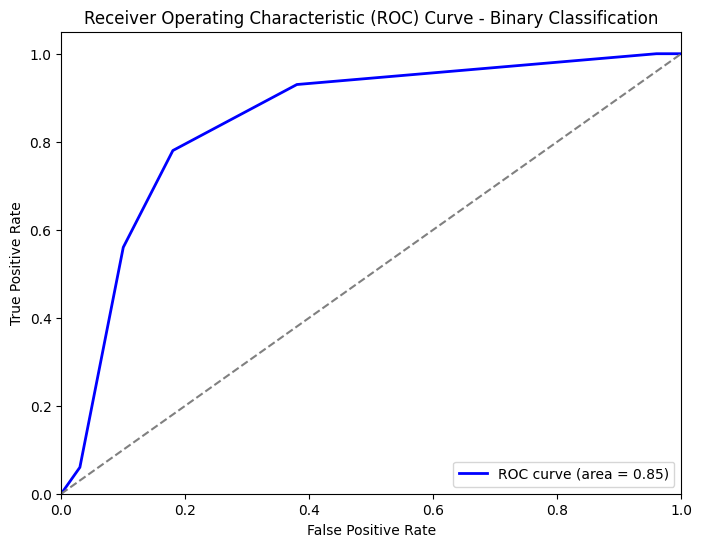

In [102]:
# Predict probabilities for the positive class (class 1)
y_pred_dt_prob = grid_search_dt.predict_proba(X_test_pca)[:, 1]  # Only need the probability for class 1 in binary case

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_dt_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Binary Classification')
plt.legend(loc="lower right")
plt.show()

# XGBoost

In [103]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [104]:
# Define and fit the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=300, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [105]:
# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(xgb_model, X_train_pca, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy Score from 10-Fold Cross-Validation:", cv_scores.mean())

10-Fold Cross-Validation Accuracy Scores: [0.8625 0.925  0.8625 0.9375 0.9    0.875  0.875  0.925  0.9375 0.925 ]
Mean Accuracy Score from 10-Fold Cross-Validation: 0.9025000000000002


In [106]:
# Predict probabilities for ROC curve
y_pred_xgb_prob = xgb_model.predict_proba(X_test_pca)

In [107]:
# Grid Search with Cross-Validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
}

In [108]:
grid_search_xgb = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train_pca, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [109]:
best_model = grid_search_xgb.best_estimator_

y_pred_xgb = best_model.predict(X_test_pca)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       100
           1       0.88      0.91      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200

XGBoost Confusion Matrix:
[[88 12]
 [ 9 91]]


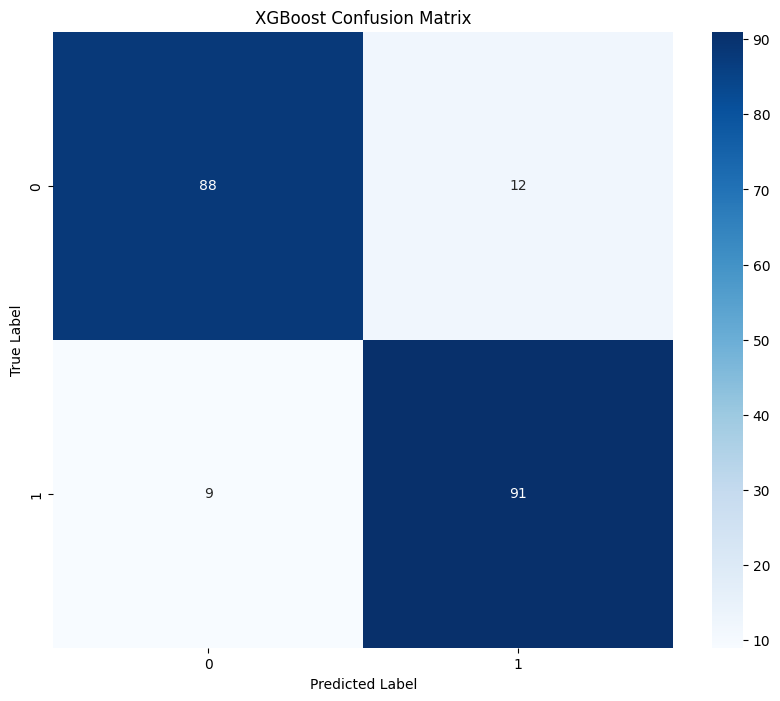

In [110]:
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("XGBoost Confusion Matrix:")
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to th

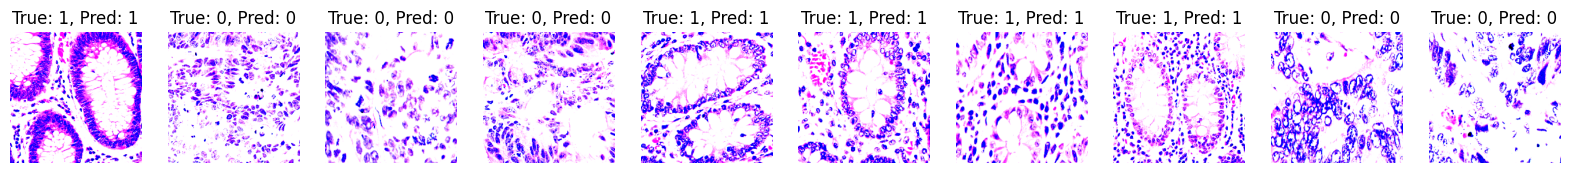

In [111]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_xgb[i]}")

plt.show()

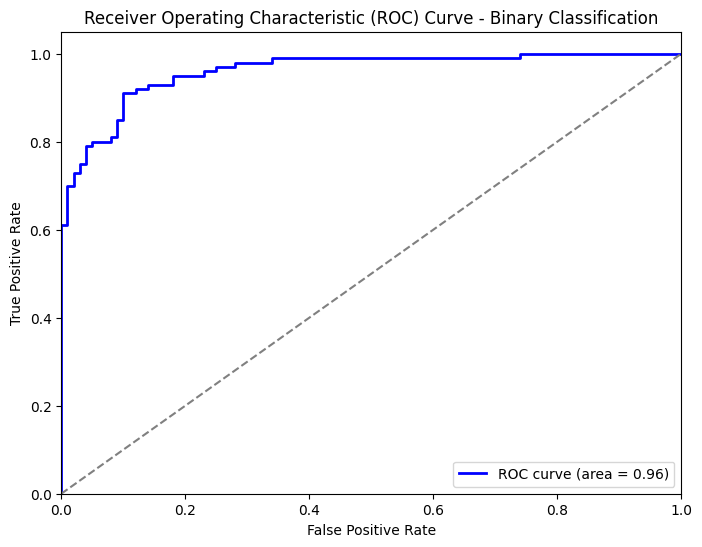

In [112]:
# Predict probabilities for the positive class (class 1)
y_pred_xgb_prob = grid_search_xgb.predict_proba(X_test_pca)[:, 1]  # Only need the probability for class 1 in binary case

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Binary Classification')
plt.legend(loc="lower right")
plt.show()